In [1]:
import numpy as np
import pandas as pd 
import tifffile
import matplotlib.pyplot as plt

from matplotlib.patches import Patch

from tqdm import tqdm

import os 

## Load data

In [2]:
annotation = pd.read_csv('../output/Annotation/final_annotation_edge_corrected.csv')

Rename some annotations

In [3]:
new_df = annotation.copy()
new_df.loc[new_df['Annotation'].str.contains('Tumor'), 'Annotation'] = 'Tumor'
new_df.loc[new_df['Annotation'].str.contains('CD8'), 'Annotation'] = 'CD8 T'
new_df.loc[new_df['Annotation'].str.contains('CD4'), 'Annotation'] = 'CD4 T'
new_df.loc[new_df['Annotation'].str.contains('M1'), 'Annotation'] = 'M1-like'
new_df.loc[new_df['Annotation'].str.contains('M2'), 'Annotation'] = 'M2-like'

In [5]:
new_df

,cellLabel,Y_cent,X_cent,coreName,Y_global,X_global,Annotation
0,133,373.104575,1579.866013,DFCI_4.1,29582.104575,5152.866013,CD8 T
1,528,548.898990,1635.474747,DFCI_4.1,29757.898990,5208.474747,CD8 T
2,562,560.189189,1740.885135,DFCI_4.1,29769.189189,5313.885135,CD8 T
3,659,593.416290,1252.149321,DFCI_4.1,29802.416290,4825.149321,CD8 T
4,684,600.568266,1752.468635,DFCI_4.1,29809.568266,5325.468635,CD8 T
...,...,...,...,...,...,...,...
1725886,75625,5056.089385,3904.273743,Rochester_TonsilA,41384.089385,29836.273743,M2-like
1725887,75738,5074.551724,3305.870690,Rochester_TonsilA,41402.551724,29237.870690,M2-like
1725888,76098,5161.192405,3270.516456,Rochester_TonsilA,41489.192405,29202.516456,M2-like
1725889,76209,5183.466321,3394.492228,Rochester_TonsilA,41511.466321,29326.492228,M2-like


## Define color palette

In [4]:
DFCI_celltype_color = {
    "CD8mem": "#4F5CF6",
    "Other": "#D3D3D3E6",
    "Tumor": "#C85022",
    "Neutrophil": "#BC965B",
    "Endothelial": "#F8D949",
    "Treg": "#CB2B90",
    "CD4naive": "#4DA966",
    "DC": "#7B16F5",
    "CD8naive": "#EA3343",
    "CD4mem": "#EF8933",
    "M2": "#48A0C4",
    "M1": "#7BCA3D",
    "B cell": "#FEFBCC"
}

Rochester_celltype_color = {
    "CD8mem": "#4F5CF6",
    "Other": "#D3D3D3E6",
    "Tumor": "#C85022",
    "Neutrophil": "#C85022",
    "Endothelial": "#7B16F5",
    "Treg": "#7BCA3D",
    "CD4naive": "#64B7F9",
    "DC": "#EA3343",
    "CD8naive": "#59C2A1",
    "CD4mem": "#4DA966",
    "M2": "#48A0C4",
    "M1": "#BC965B",
    "B cell": "#C3EE4B"
}


celltype_color = {"Tumor" : "#e51d1d", 
                      "CD8 T" : "#377eb8", 
                      "CD4 T" : "#4eaf49", 
                      "M1-like" : "#974da2", 
                      "M2-like" : "#ff8000", 
                      "DC" : "#83e3f0", 
                      "Endothelial" : "#c67f66", 
                      "Treg" : "#9ED900", 
                      "B cell" : "#e89ff0",
                    "Other": "#D3D3D3E6",
                    "Neutrophil": "#C85022"}

## Subset a core to test

In [6]:
toy_data = new_df[new_df['coreName'] == 'DFCI_4.1']

In [7]:
toy_data

,cellLabel,Y_cent,X_cent,coreName,Y_global,X_global,Annotation
0,133,373.104575,1579.866013,DFCI_4.1,29582.104575,5152.866013,CD8 T
1,528,548.898990,1635.474747,DFCI_4.1,29757.898990,5208.474747,CD8 T
2,562,560.189189,1740.885135,DFCI_4.1,29769.189189,5313.885135,CD8 T
3,659,593.416290,1252.149321,DFCI_4.1,29802.416290,4825.149321,CD8 T
4,684,600.568266,1752.468635,DFCI_4.1,29809.568266,5325.468635,CD8 T
...,...,...,...,...,...,...,...
28532,28455,3792.737705,1846.754098,DFCI_4.1,33001.737705,5419.754098,Tumor
28533,28467,3796.529070,2666.697674,DFCI_4.1,33005.529070,6239.697674,Other
28534,28472,3798.434783,2650.965217,DFCI_4.1,33007.434783,6223.965217,Other
28535,28512,3819.553073,2514.726257,DFCI_4.1,33028.553073,6087.726257,Tumor


In [8]:
toy_seg = tifffile.imread('../output/seg_results/DFCI/core_4.1/MESMER_mask.tiff')

outline = tifffile.imread('../output/seg_results/DFCI/core_4.1/overlay.tiff')[...,0]

outline_mask = outline == 1

In [12]:
import numpy as np

# Assuming you have the following variables:
# - cell_label_to_annotation: a dictionary mapping cellLabel to annotation
# - segmentation_mask: a 2D numpy array representing the segmentation mask, where each pixel value is the cellLabel

# Create a new RGB image with the same dimensions as the segmentation mask
colored_mask = np.zeros((toy_seg.shape[0], toy_seg.shape[1], 3), dtype=np.uint8)

# Get the unique cellLabels in the segmentation mask, excluding 0
unique_labels = np.unique(toy_seg[toy_seg != 0])

# Create a mapping array to store the RGB color for each cellLabel
color_mapping = np.zeros((np.max(unique_labels) + 1, 3), dtype=np.uint8)

# Iterate over each unique cellLabel and assign the corresponding color
for cellLabel in unique_labels:
    annotation = toy_data['Annotation'][toy_data['cellLabel'] == cellLabel].values[0]
    color_code = celltype_color[annotation]
    rgb_color = tuple(int(color_code[i:i+2], 16) for i in (1, 3, 5))
    color_mapping[cellLabel] = rgb_color

# Use the color mapping array to assign colors to the segmentation mask
colored_mask = color_mapping[toy_seg]

# Set the outline pixels to white
colored_mask[outline_mask] = (255, 255, 255)

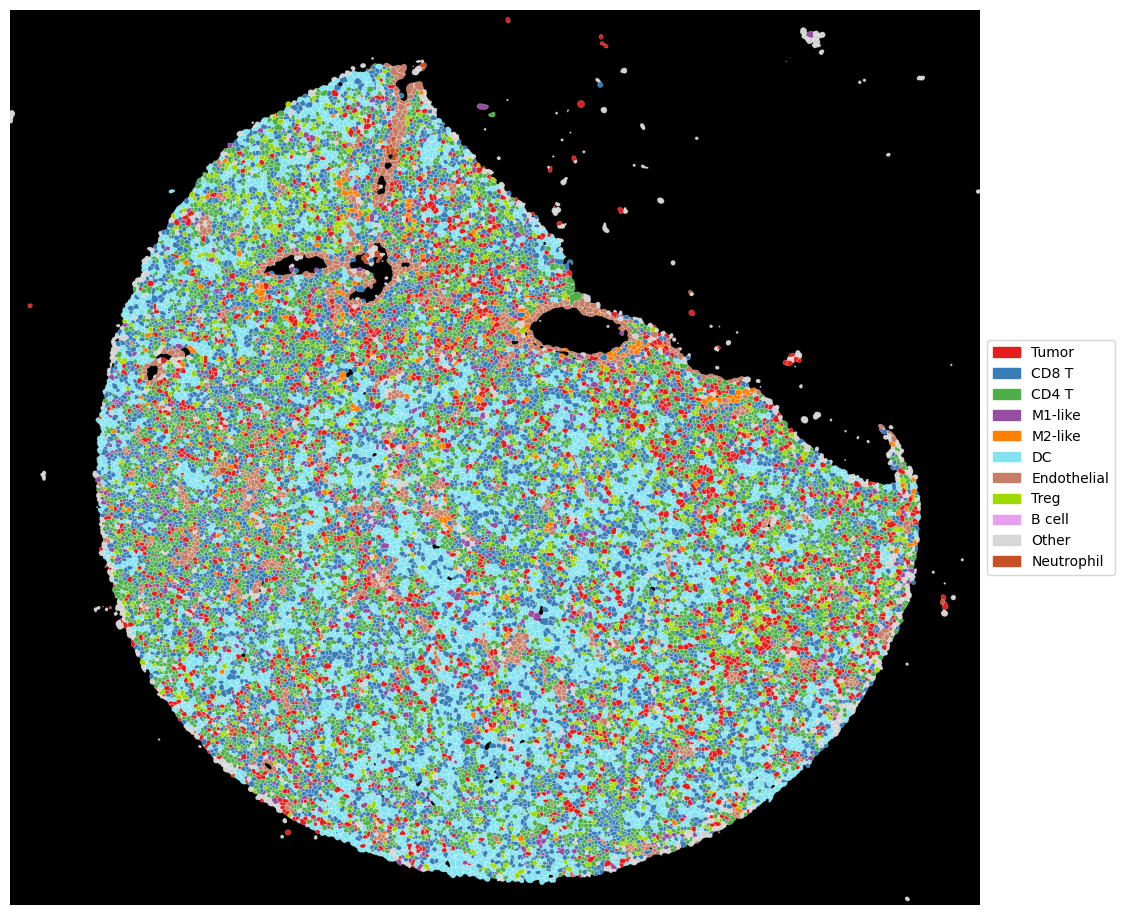

In [13]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(colored_mask)
plt.axis('off')
plt.tight_layout()
# Create a list of legend handles and labels
legend_handles = []
legend_labels = []

# Iterate over the cell types and colors
for celltype, color in celltype_color.items():
    # Create a Patch for each cell type
    patch = Patch(color=color, label=celltype)
    legend_handles.append(patch)
    legend_labels.append(celltype)

# Create the legend
ax1.legend(handles=legend_handles, labels=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')

plt.show()

## Loop through all cores

In [5]:
for core in tqdm(new_df['coreName'].unique()):
    print(core)
    if 'DFCI' in core:
        sub_data = new_df[new_df['coreName'] == core]

        core_num = core.split('_')[1]

        seg = tifffile.imread(f'../output/seg_results/DFCI/core_{core_num}/MESMER_mask.tiff')

        outline = tifffile.imread(f'../output/seg_results/DFCI/core_{core_num}/overlay.tiff')[...,0]

        outline_mask = outline == 1
        # Create a new RGB image with the same dimensions as the segmentation mask
        colored_mask = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)

        # Get the unique cellLabels in the segmentation mask, excluding 0
        unique_labels = np.unique(seg[seg != 0])

        # Create a mapping array to store the RGB color for each cellLabel
        color_mapping = np.zeros((np.max(unique_labels) + 1, 3), dtype=np.uint8)

        # Iterate over each unique cellLabel and assign the corresponding color
        for cellLabel in unique_labels:
            annotation = sub_data['Annotation'][sub_data['cellLabel'] == cellLabel].values
            if len(annotation) > 0:
                annotation = annotation[0]
                if annotation in celltype_color:
                    color_code = celltype_color[annotation]
                    rgb_color = tuple(int(color_code[i:i+2], 16) for i in (1, 3, 5))
                    color_mapping[cellLabel] = rgb_color
                else:
                    color_mapping[cellLabel] = (0, 0, 0)  # Assign black color for unknown annotations
            else:
                color_mapping[cellLabel] = (0, 0, 0)  # Assign black color for unannotated cellLabels

        # Use the color mapping array to assign colors to the segmentation mask
        colored_mask = color_mapping[seg]

        # Set the outline pixels to white
        colored_mask[outline_mask] = (255, 255, 255)


        fig = plt.figure(figsize=(20,20))
        ax1 = fig.add_subplot(1,1,1)
        ax1.imshow(colored_mask)
        plt.axis('off')
        plt.tight_layout()
        # Create a list of legend handles and labels
        legend_handles = []
        legend_labels = []

        # Iterate over the cell types and colors
        for celltype, color in celltype_color.items():
            # Create a Patch for each cell type
            patch = Patch(color=color, label=celltype)
            legend_handles.append(patch)
            legend_labels.append(celltype)

        # Create the legend
        ax1.legend(handles=legend_handles, labels=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')

        outpath = f'../output/phenotype_map_071124'

        if not os.path.exists(outpath):
            os.makedirs(outpath)

        plt.savefig(f'{outpath}/DFCI_{core_num}.pdf', format='pdf', bbox_inches='tight', dpi = 320)
        
        plt.close(fig)
    else:
        sub_data = new_df[new_df['coreName'] == core]

        core_num = core.split('_')[1]

        seg = tifffile.imread(f'../output/seg_results/Rochester/core_{core_num}/MESMER_mask.tiff')

        outline = tifffile.imread(f'../output/seg_results/Rochester/core_{core_num}/overlay.tiff')[...,0]

        outline_mask = outline == 1
        # Create a new RGB image with the same dimensions as the segmentation mask
        colored_mask = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)

        # Get the unique cellLabels in the segmentation mask, excluding 0
        unique_labels = np.unique(seg[seg != 0])

        # Create a mapping array to store the RGB color for each cellLabel
        color_mapping = np.zeros((np.max(unique_labels) + 1, 3), dtype=np.uint8)

        # Iterate over each unique cellLabel and assign the corresponding color
        for cellLabel in unique_labels:
            annotation = sub_data['Annotation'][sub_data['cellLabel'] == cellLabel].values
            if len(annotation) > 0:
                annotation = annotation[0]
                if annotation in celltype_color:
                    color_code = celltype_color[annotation]
                    rgb_color = tuple(int(color_code[i:i+2], 16) for i in (1, 3, 5))
                    color_mapping[cellLabel] = rgb_color
                else:
                    color_mapping[cellLabel] = (0, 0, 0)  # Assign black color for unknown annotations
            else:
                color_mapping[cellLabel] = (0, 0, 0)  # Assign black color for unannotated cellLabels

        # Use the color mapping array to assign colors to the segmentation mask
        colored_mask = color_mapping[seg]

        # Set the outline pixels to white
        colored_mask[outline_mask] = (255, 255, 255)


        fig = plt.figure(figsize=(20,20))
        ax1 = fig.add_subplot(1,1,1)
        ax1.imshow(colored_mask)
        plt.axis('off')
        plt.tight_layout()
        # Create a list of legend handles and labels
        legend_handles = []
        legend_labels = []

        # Iterate over the cell types and colors
        for celltype, color in celltype_color.items():
            # Create a Patch for each cell type
            patch = Patch(color=color, label=celltype)
            legend_handles.append(patch)
            legend_labels.append(celltype)

        # Create the legend
        ax1.legend(handles=legend_handles, labels=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')

        outpath = f'../output/phenotype_map_071124'

        if not os.path.exists(outpath):
            os.makedirs(outpath)

        plt.savefig(f'{outpath}/Rochester_{core_num}.pdf', format='pdf', bbox_inches='tight',dpi = 320)
        
        plt.close(fig)


        
                

  0%|          | 0/42 [00:00<?, ?it/s]

DFCI_4.1


  2%|▏         | 1/42 [00:10<06:56, 10.16s/it]

DFCI_8.1


  5%|▍         | 2/42 [00:22<07:35, 11.39s/it]

DFCI_9.1


  7%|▋         | 3/42 [00:33<07:12, 11.09s/it]

DFCI_13.2


 10%|▉         | 4/42 [00:44<07:00, 11.06s/it]

DFCI_15.2


 12%|█▏        | 5/42 [00:53<06:31, 10.59s/it]

DFCI_17.1


 14%|█▍        | 6/42 [01:04<06:16, 10.46s/it]

DFCI_18.2


 17%|█▋        | 7/42 [01:16<06:22, 10.94s/it]

DFCI_19.2


 19%|█▉        | 8/42 [01:27<06:19, 11.16s/it]

DFCI_22.2


 21%|██▏       | 9/42 [01:37<05:56, 10.79s/it]

DFCI_11.1


 24%|██▍       | 10/42 [01:45<05:15,  9.87s/it]

DFCI_12.1


 26%|██▌       | 11/42 [01:56<05:12, 10.08s/it]

DFCI_14.1


 29%|██▊       | 12/42 [02:04<04:51,  9.73s/it]

DFCI_2.2


 31%|███       | 13/42 [02:14<04:41,  9.72s/it]

DFCI_21.1


 33%|███▎      | 14/42 [02:21<04:10,  8.93s/it]

DFCI_3.2


 36%|███▌      | 15/42 [02:31<04:06,  9.14s/it]

DFCI_6.1


 38%|███▊      | 16/42 [02:41<04:06,  9.49s/it]

DFCI_7.1


 40%|████      | 17/42 [02:51<03:56,  9.47s/it]

DFCI_1.2


 43%|████▎     | 18/42 [02:59<03:36,  9.02s/it]

DFCI_23.2


 45%|████▌     | 19/42 [03:06<03:14,  8.45s/it]

DFCI_Tonsil1


 48%|████▊     | 20/42 [03:17<03:24,  9.28s/it]

Rochester_4


 50%|█████     | 21/42 [03:43<05:00, 14.32s/it]

Rochester_5


 52%|█████▏    | 22/42 [04:04<05:23, 16.19s/it]

Rochester_6


 55%|█████▍    | 23/42 [04:22<05:23, 17.01s/it]

Rochester_10


 57%|█████▋    | 24/42 [04:36<04:49, 16.07s/it]

Rochester_11


 60%|█████▉    | 25/42 [04:55<04:44, 16.76s/it]

Rochester_12


 62%|██████▏   | 26/42 [05:11<04:25, 16.61s/it]

Rochester_14


 64%|██████▍   | 27/42 [05:28<04:12, 16.80s/it]

Rochester_18


 67%|██████▋   | 28/42 [05:48<04:05, 17.55s/it]

Rochester_19


 69%|██████▉   | 29/42 [06:11<04:09, 19.21s/it]

Rochester_21


 71%|███████▏  | 30/42 [06:29<03:47, 18.95s/it]

Rochester_22


 74%|███████▍  | 31/42 [06:54<03:47, 20.64s/it]

Rochester_23


 76%|███████▌  | 32/42 [07:14<03:24, 20.49s/it]

Rochester_1


 79%|███████▊  | 33/42 [07:37<03:12, 21.44s/it]

Rochester_13


 81%|████████  | 34/42 [07:57<02:46, 20.85s/it]

Rochester_15


 83%|████████▎ | 35/42 [08:15<02:19, 19.99s/it]

Rochester_17


 86%|████████▌ | 36/42 [08:31<01:52, 18.77s/it]

Rochester_25


 88%|████████▊ | 37/42 [08:44<01:25, 17.12s/it]

Rochester_7


 90%|█████████ | 38/42 [09:04<01:11, 17.88s/it]

Rochester_8


 93%|█████████▎| 39/42 [09:26<00:57, 19.11s/it]

Rochester_9


 95%|█████████▌| 40/42 [09:39<00:34, 17.29s/it]

Rochester_16


 98%|█████████▊| 41/42 [09:54<00:16, 16.73s/it]

Rochester_TonsilA


100%|██████████| 42/42 [10:14<00:00, 14.64s/it]
